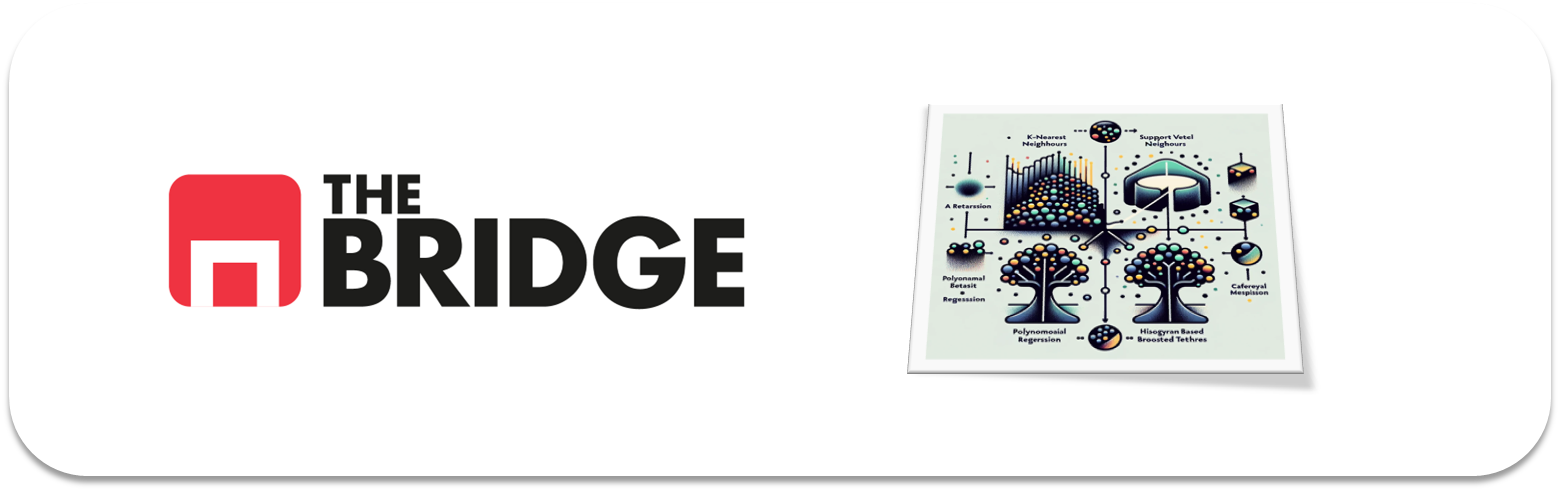

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [6]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import ToolBox as tb

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [2]:
df = pd.read_csv("./data/wines_dataset.csv", sep = "|")

In [4]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
df.head ()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red


In [7]:
tb.describe_df (df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
DATA_TYPE,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,106,187,89,316,214,135,276,998,108,111,111,7,2
CARDIN (%),1.63,2.88,1.37,4.86,3.29,2.08,4.25,15.36,1.66,1.71,1.71,0.11,0.03


In [10]:
tb.tipifica_variables (df,10,15)

,nombre_variable,tipo_sugerido
0,fixed acidity,Numérica Discreta
1,volatile acidity,Numérica Discreta
2,citric acid,Numérica Discreta
3,residual sugar,Numérica Discreta
4,chlorides,Numérica Discreta
5,free sulfur dioxide,Numérica Discreta
6,total sulfur dioxide,Numérica Discreta
7,density,Numérica Continua
8,pH,Numérica Discreta
9,sulphates,Numérica Discreta


In [11]:
target_clf = "quality"
target_reg = "alcohol"

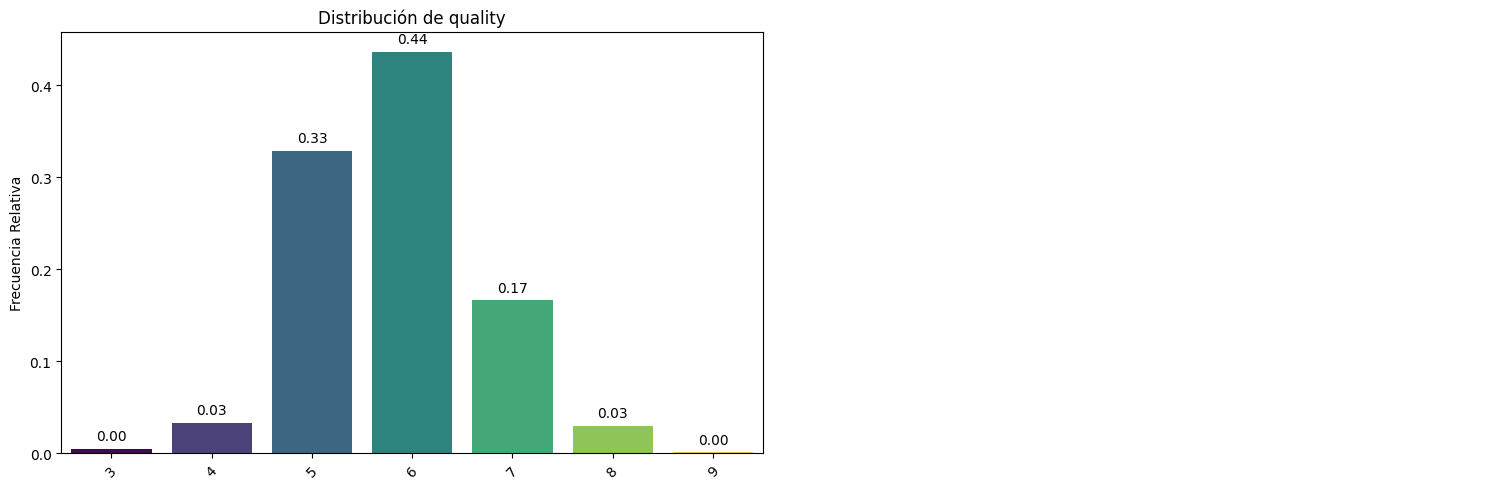

In [12]:
bt.pinta_distribucion_categoricas(df, [target_clf], mostrar_valores = True, relativa = True)

<Axes: xlabel='alcohol', ylabel='Count'>

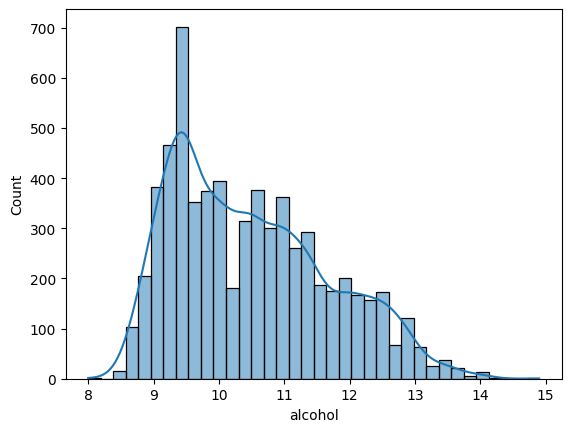

In [13]:
sns.histplot(df[target_reg], kde = True)

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

In [14]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)


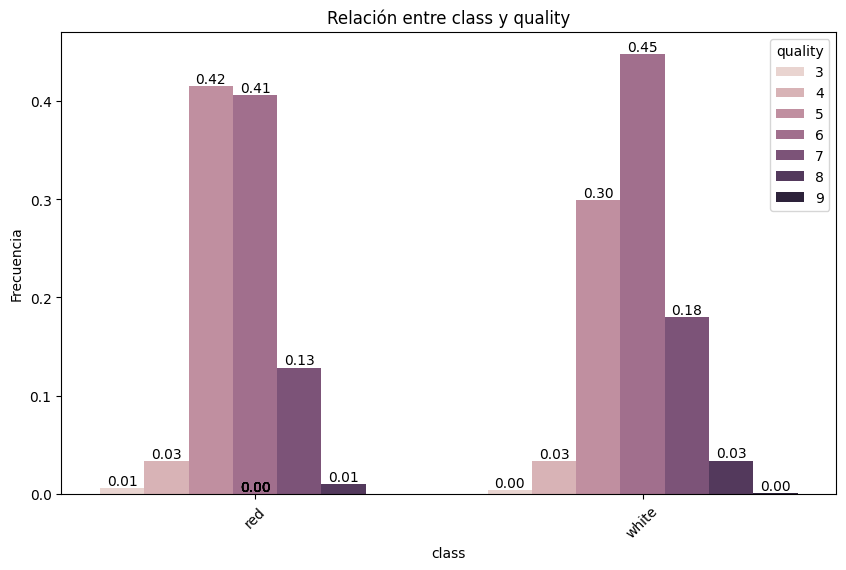

In [15]:
bt.plot_categorical_relationship_fin(train_set, "class", target_clf, show_values= True, relative_freq= True)


In [16]:
features_cat_clf = ["class"]

In [17]:
features_num_clf = [col for col in train_set.columns if col != "class" and col != target_clf] # Me quedo con todas que no son categóricas, ni el target
print(len(features_num_clf)) # Veo cuantas son para saber qué utilizar si pairplot o las funciones de bt

11


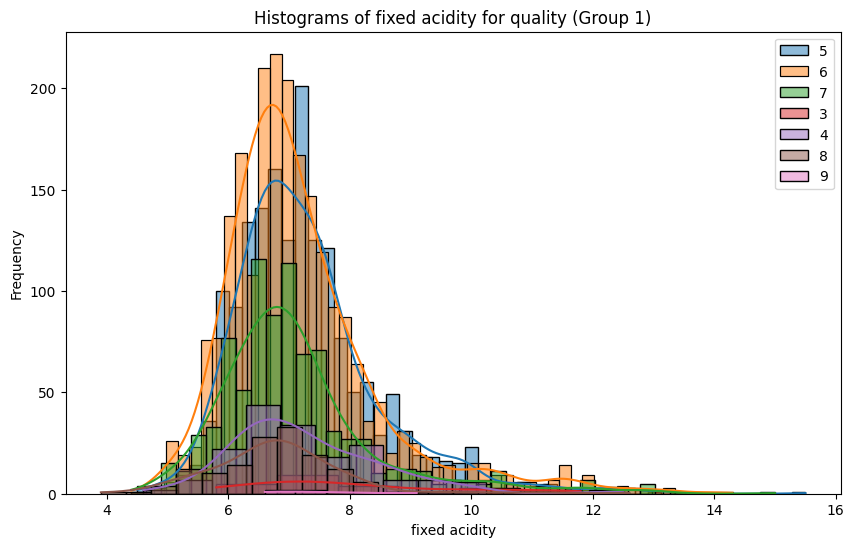

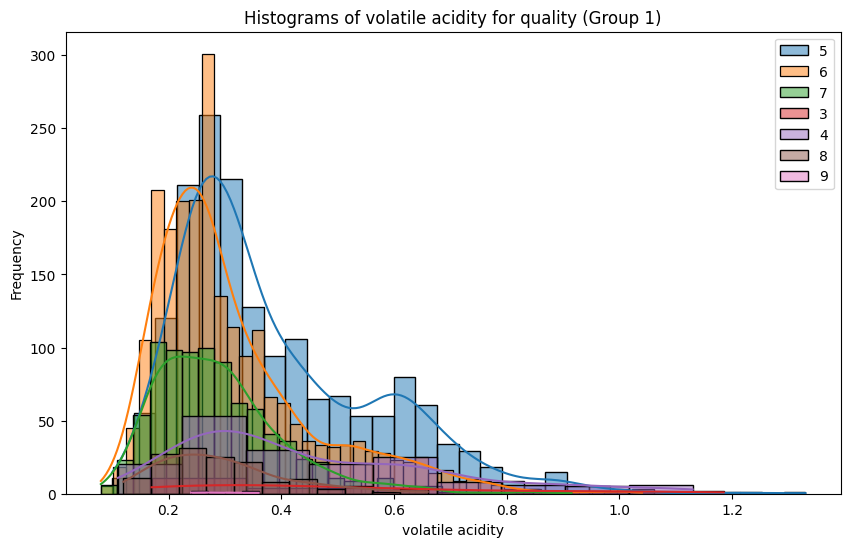

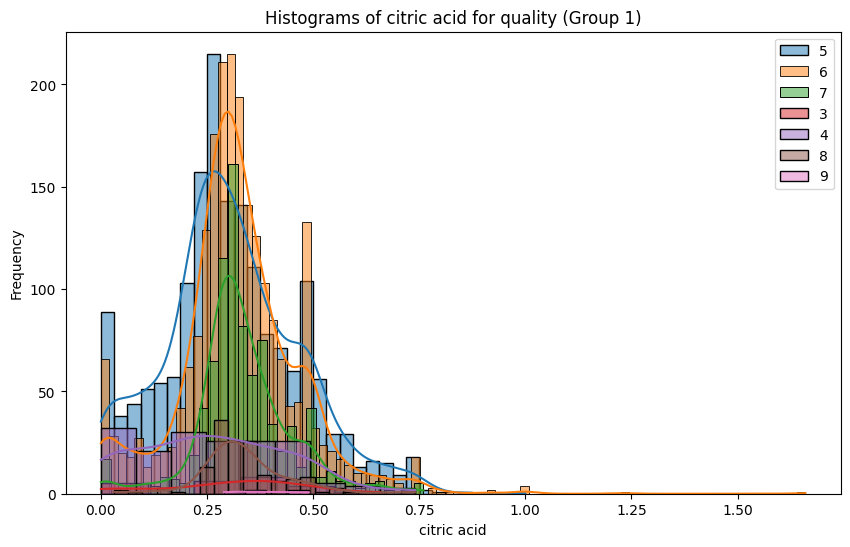

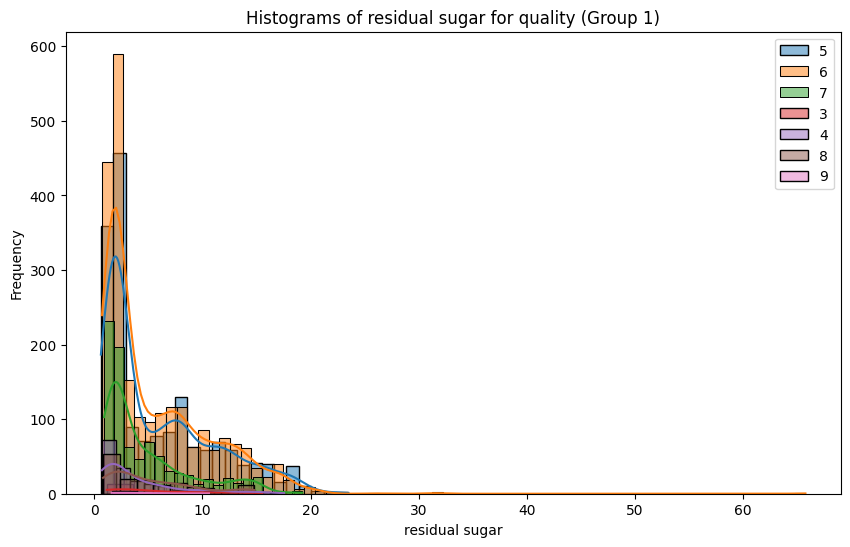

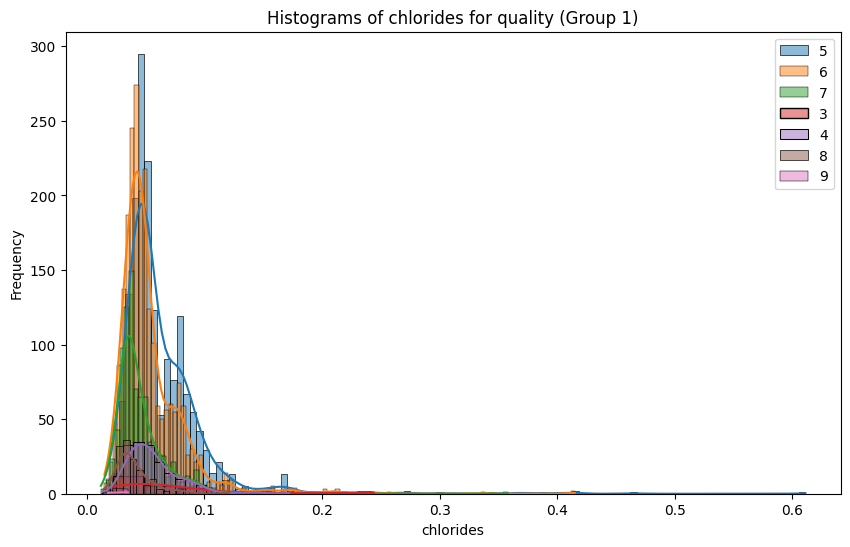

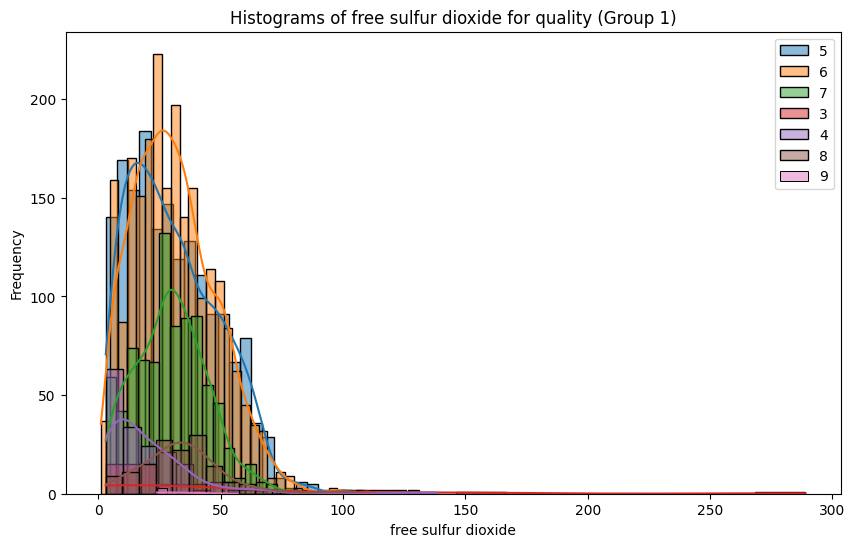

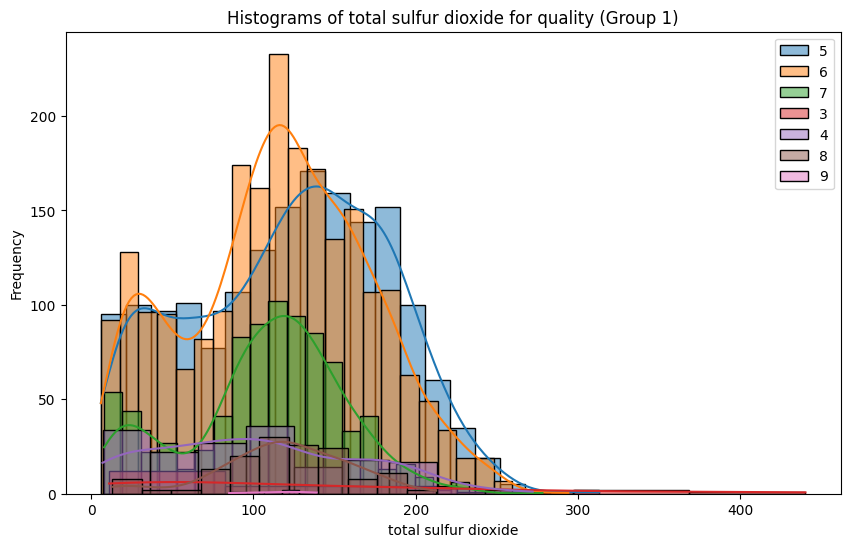

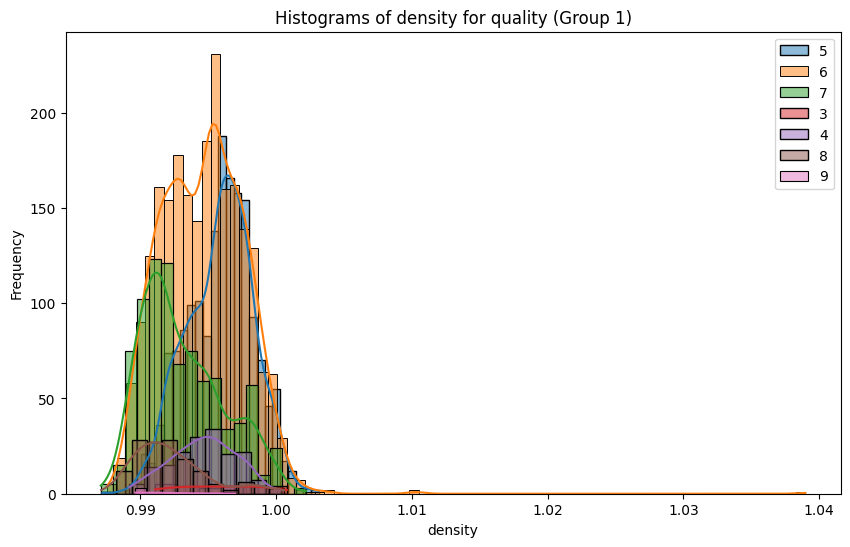

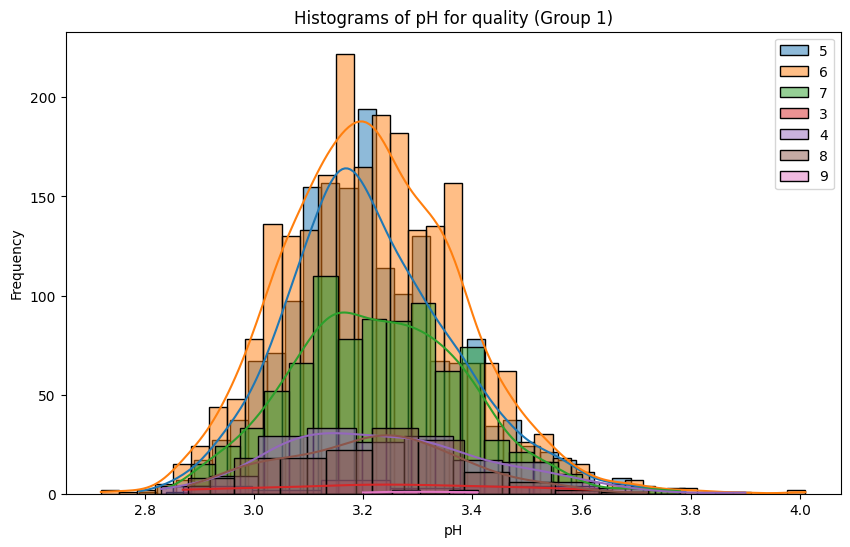

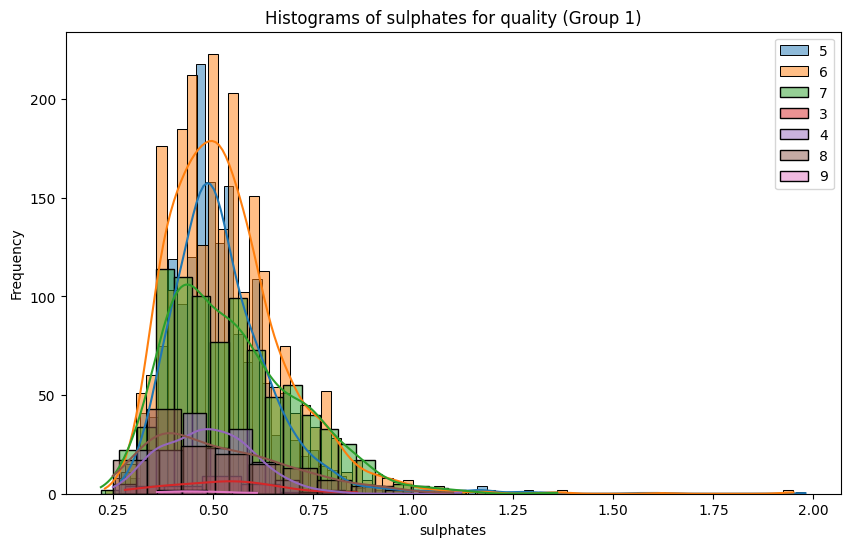

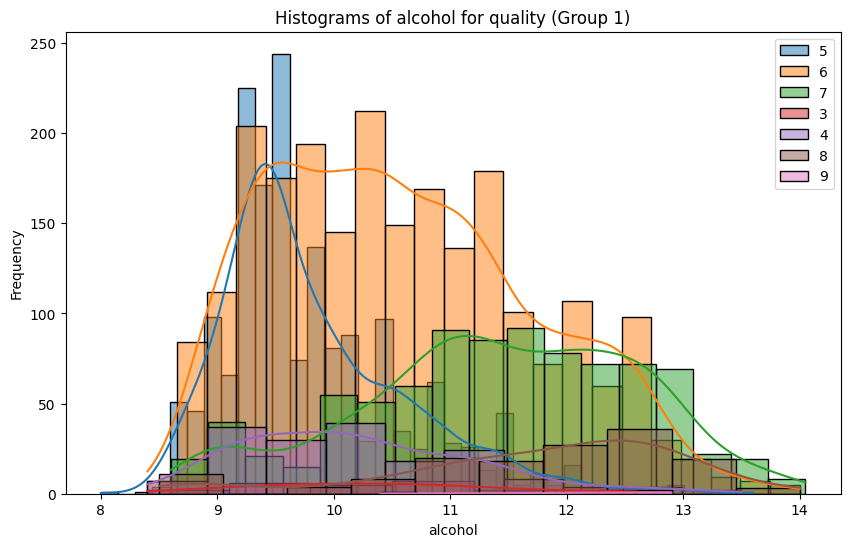

In [18]:
for col in features_num_clf:
    bt.plot_grouped_histograms(train_set, cat_col= target_clf, num_col= col, group_size= train_set[target_clf].nunique())

In [19]:
corr = train_set.corr(numeric_only= True)
corr[target_clf]

fixed acidity          -0.071698
volatile acidity       -0.255368
citric acid             0.096020
residual sugar         -0.039630
chlorides              -0.197389
free sulfur dioxide     0.039678
total sulfur dioxide   -0.050816
density                -0.305107
pH                      0.011918
sulphates               0.052398
alcohol                 0.450403
quality                 1.000000
Name: quality, dtype: float64

In [20]:
featues_num_clf_1 = ["volatile acidity","citric acid","chlorides","free sulfur dioxide","total sulfur dioxide", "density","pH","sulphates","alcohol"]
features_num_clf_2 = ["fixed acidity","residual sugar"]

In [21]:
features_cat_reg = ["class","quality"]

In [23]:
corr = train_set.corr(numeric_only= "True")
np.abs(corr[target_reg]).sort_values(ascending = False)

alcohol                 1.000000
density                 0.682345
quality                 0.450403
residual sugar          0.357459
total sulfur dioxide    0.272970
chlorides               0.260508
free sulfur dioxide     0.188460
pH                      0.116497
fixed acidity           0.091964
volatile acidity        0.036041
citric acid             0.005690
sulphates               0.000412
Name: alcohol, dtype: float64

In [24]:
r_min = 0.10
features_num_reg_1 = corr[target_reg][(np.abs(corr[target_reg]) > r_min)].index.to_list()
features_num_reg_1.remove("quality")
features_num_reg_2 = [col for col in train_set.columns if col not in features_num_reg_1 and col != target_reg
                       and col not in features_cat_reg]

<Axes: >

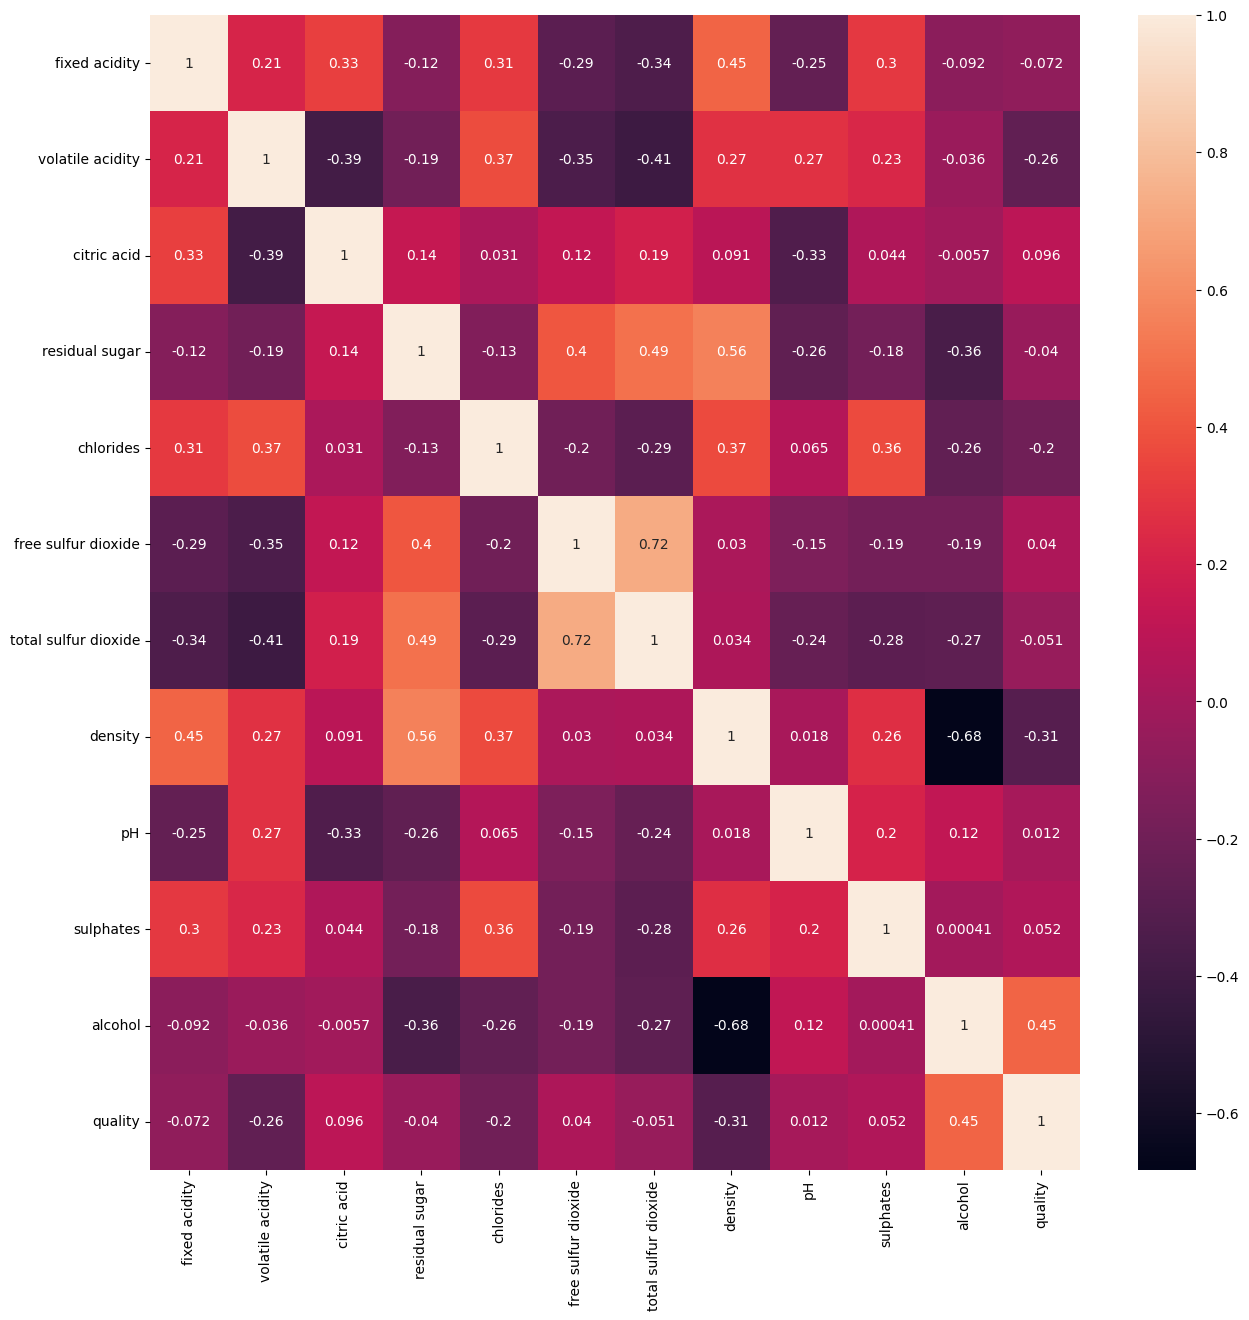

In [29]:
plt.figure(figsize= (15,15))
sns.heatmap(corr, annot= True)

In [30]:
features_num_reg_1.remove("free sulfur dioxide") 
features_num_reg_2.append("free sulfur dioxide")

In [32]:
train_set["class"] = (train_set["class"] == "white").astype(int)
test_set["class"] = (test_set["class"] == "white").astype(int)

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

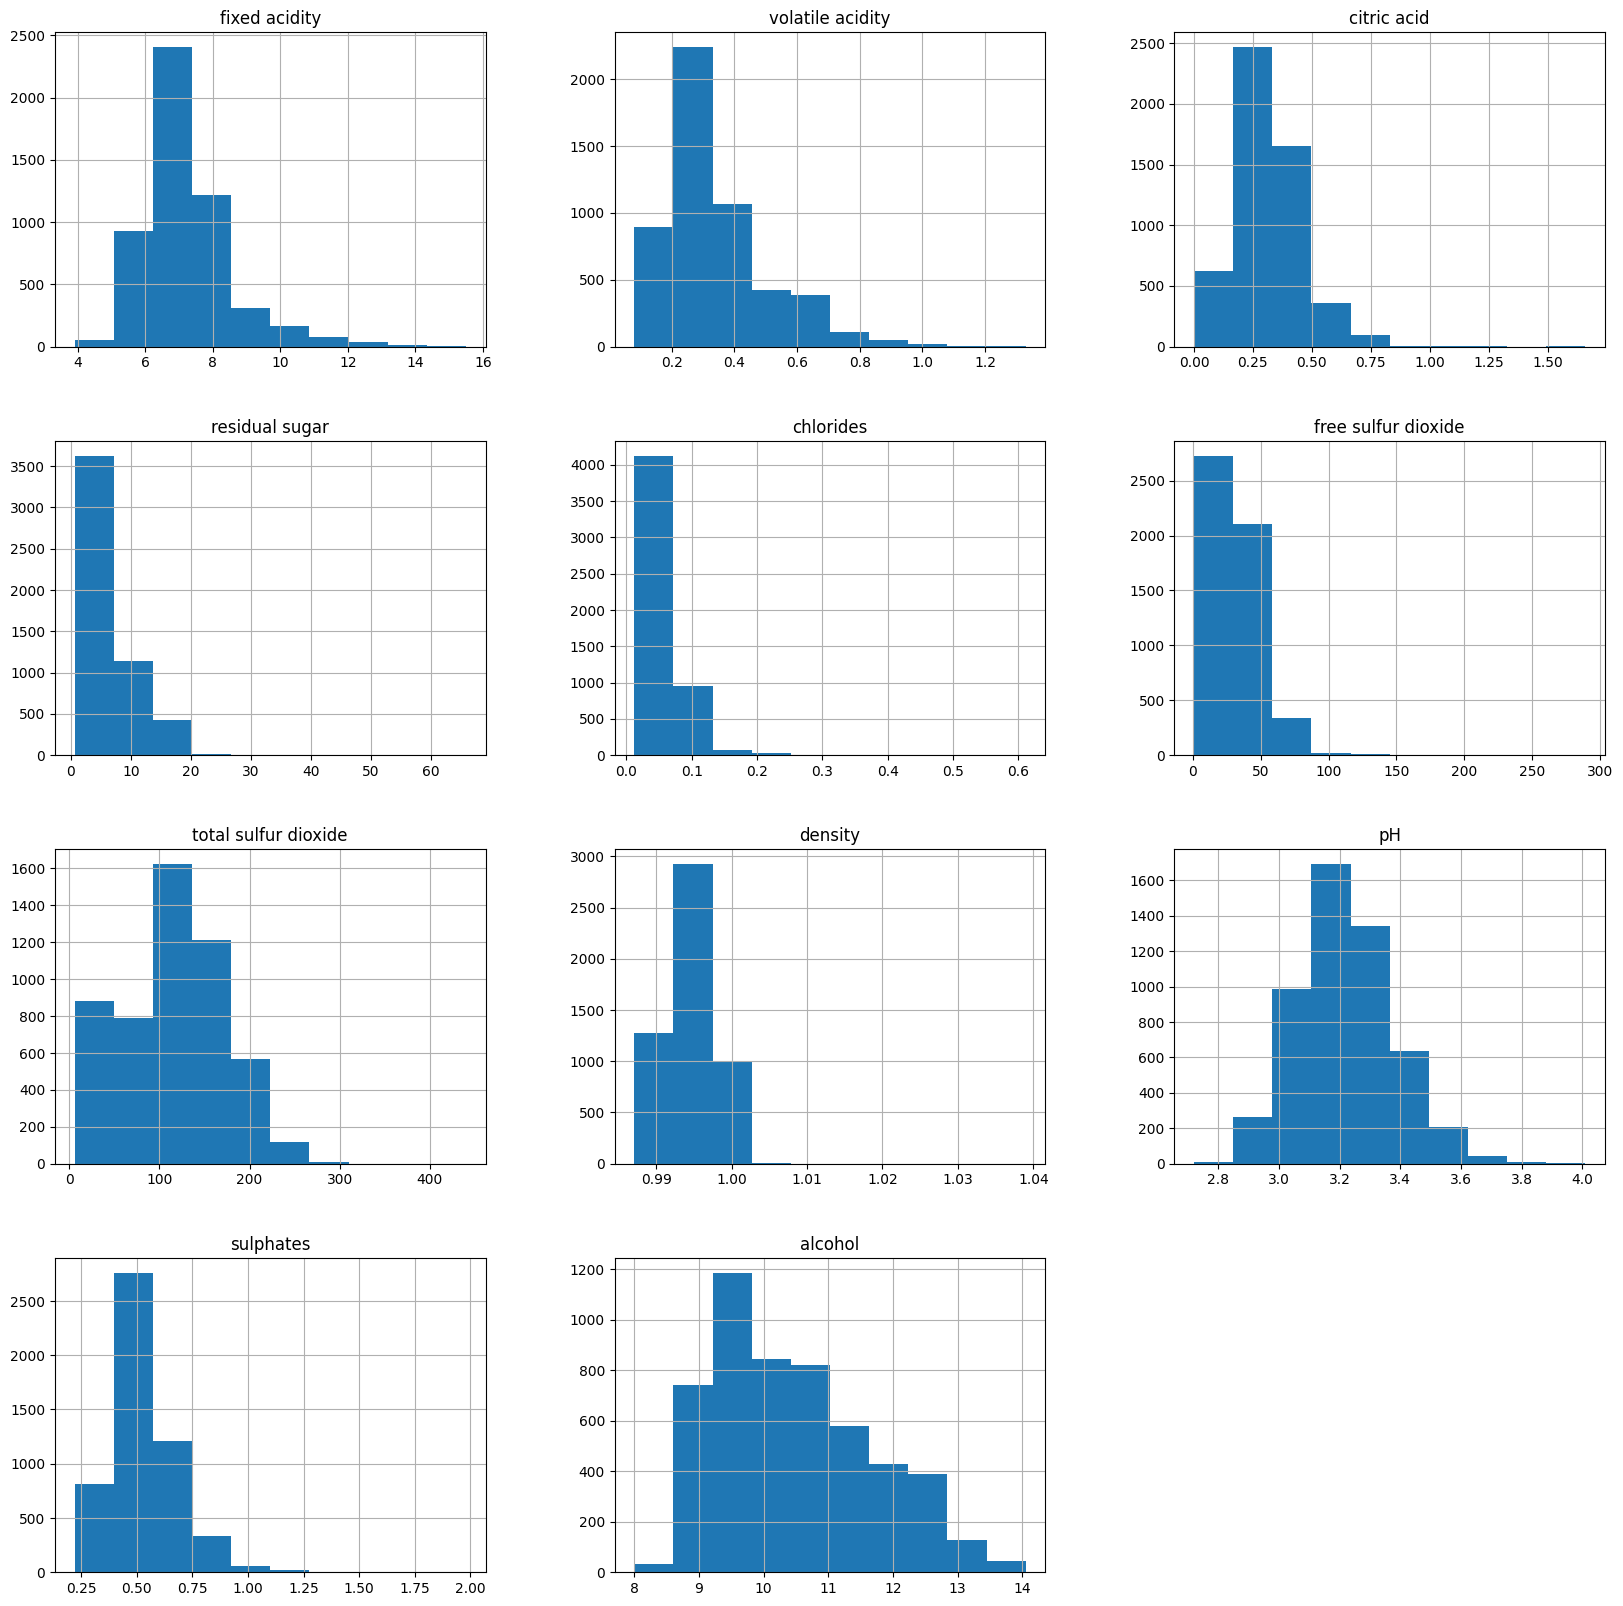

In [33]:
train_set[features_num_clf].hist(figsize = (20,20))
plt.tight_layout

In [34]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [35]:
features_to_transform = ["residual sugar", "chlorides","free sulfur dioxide", "total sulfur dioxide"]

In [36]:
for col in features_to_transform:
    desplaza = 0 
    if train_set_scaled[col].min() <= 0:
        desplaza = int(abs(train_set_scaled[col].min())) + 1
    train_set_scaled[col] = np.log(train_set_scaled[col] + desplaza)
    test_set_scaled[col] = np.log(test_set_scaled[col] + desplaza)

In [37]:
features_num_clf

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [38]:
scaler = StandardScaler()
features_num_reg = features_num_clf.copy()
features_num_reg.remove("alcohol")
train_set_scaled[features_num_reg] = scaler.fit_transform(train_set_scaled[features_num_reg])
test_set_scaled[features_num_reg] = scaler.transform(test_set_scaled[features_num_reg])


In [39]:
train_set_scaled_clf = train_set_scaled.copy()
test_set_scaled_clf = test_set_scaled.copy()

train_set_scaled_clf["alcohol"] = scaler.fit_transform(train_set_scaled_clf[["alcohol"]])
test_set_scaled_clf["alcohol"] = scaler.transform(test_set_scaled_clf[["alcohol"]])

In [42]:
y_train_clf = train_set[target_clf]
y_test_clf = test_set[target_clf]
y_train_reg = train_set[target_reg]
y_test_reg = test_set[target_reg]


X_train_clf_dict = {}
X_test_clf_dict = {}

X_train_reg_dict = {}
X_test_reg_dict = {}

# Juegos X_train clasificacion

features_set_name = ["cat+num_1","todas"]
features_set = [features_cat_clf + featues_num_clf_1, features_cat_clf + featues_num_clf_1 + features_num_clf_2]

for set_name,feature_list in zip(features_set_name, features_set):
    print(feature_list)
    X_train_clf_dict[set_name] = train_set_scaled_clf[feature_list]
    X_test_clf_dict[set_name] = test_set_scaled_clf[feature_list]

# Juegos X_train regresion
    
features_set_name = ["cat+num_1","todas"]
features_set = [features_cat_reg + features_num_reg_1, features_cat_reg + features_num_reg_1 + features_num_reg_2]

for set_name,feature_list in zip(features_set_name, features_set):
    X_train_reg_dict[set_name] = train_set_scaled[feature_list]
    X_test_reg_dict[set_name] = test_set_scaled[feature_list]

['class', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
['class', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'fixed acidity', 'residual sugar']


In [43]:
# Instanciamos modelos
knn_clf = KNeighborsClassifier(n_neighbors= 5)
knn_ten_clf = KNeighborsClassifier(n_neighbors= 10)
lr_clf = LogisticRegression(max_iter = 1000)
rf_clf = RandomForestClassifier(max_depth = 10, random_state= 42)
lgb_clf = LGBMClassifier(max_depth = 10, random_state = 42, verbose = -100)

modelos_clf = {
    "KNN_5": knn_clf,
    "KNN_10": knn_ten_clf,
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}

In [44]:
for feature_set, X_train in X_train_clf_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_clf.items():
        print(f"{tipo}: ", end = " ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_clf, cv = 5, scoring = "balanced_accuracy")))
    print("******")

Para el set cat+num_1:
KNN_5:  0.2512169341214729
KNN_10:  0.23960669681190927
Regresion Logistica:  0.22268625045066254
Random Forest:  0.276154216347825
LightGBM:  0.32906975061175736
******
Para el set todas:
KNN_5:  0.25493148008487865
KNN_10:  0.24220232520541077
Regresion Logistica:  0.22435666929889103
Random Forest:  0.27297817289130333
LightGBM:  0.3357836545911659
******


In [45]:
for feature_set, X_train in X_train_clf_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_clf.items():
        print(f"{tipo}: ", end = " ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_clf, cv = 5, scoring = "balanced_accuracy")))
    print("-------------------")

Para el set cat+num_1:
KNN_5:  0.2512169341214729
KNN_10:  0.23960669681190927
Regresion Logistica:  0.22268625045066254
Random Forest:  0.276154216347825
LightGBM:  0.32906975061175736
-------------------
Para el set todas:
KNN_5:  0.25493148008487865
KNN_10:  0.24220232520541077
Regresion Logistica:  0.22435666929889103
Random Forest:  0.27297817289130333
LightGBM:  0.3357836545911659
-------------------


### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [48]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)

modelos_reg = {
    "Random Forest": rf_reg,
    "LightGBM": lgb_reg,
    "XGBoost Regressor": xgb_reg
}


In [49]:
for feature_set, X_train in X_train_reg_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_reg.items():
        print(f"{tipo}: ", end = " ")
        print(-np.mean(cross_val_score(modelo, X_train, y_train_reg, cv = 5, scoring = "neg_mean_absolute_percentage_error")))
    print("-----------------")

Para el set cat+num_1:
Random Forest:  4.7888455418113614e-05
LightGBM:  0.00027603377863354053
XGBoost Regressor:  4.337408672343086e-05
-----------------
Para el set todas:
Random Forest:  5.542288471222373e-05
LightGBM:  0.00027387429480069754
XGBoost Regressor:  4.954850314471324e-05
-----------------


In [50]:
param_grid = {
    "n_estimators": [100,200,1000],
    "max_depth": [1,5,10,20],
    "max_features": ["log2","sqrt",None]
}

rf_grid = GridSearchCV(rf_reg,
                        param_grid= param_grid,
                        cv = 5,
                        scoring = "neg_mean_absolute_percentage_error")

rf_grid.fit(X_train_reg_dict["todas"], y_train_reg)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=10, random_state=42),
             param_grid={'max_depth': [1, 5, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'n_estimators': [100, 200, 1000]},
             scoring='neg_mean_absolute_percentage_error')

In [51]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'max_depth': 20, 'max_features': None, 'n_estimators': 100}
-5.494613932398402e-05


In [52]:
y_pred = rf_grid.best_estimator_.predict(X_test_reg_dict["todas"])
print("MAPE:", mean_absolute_percentage_error(y_test_reg, y_pred))

MAPE: 0.0001143925554820468
